<a href="https://colab.research.google.com/github/Jsk10101/PlanetarySci-Phys5205/blob/main/Modeling_Earth_Using_Central_Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac

# Constants
G = ac.G.value                      # Gravitational constant in m^3 / (kg s^2)
me = ac.M_earth.value               # Earth mass in kg
re = ac.R_earth.value               # Earth radius in m
gpa_to_pa = 1e9                     # Conversion factor: 1 GPa = 1e9 Pa

# Constant densities in kg/m³
constant_density_Fe = 11350.0      # Core density
constant_density_sil = 4500.0      # Mantle density

# Calculate radius of the core
core_radius = (((3 * me)/(4*np.pi) - (re**3 * constant_density_sil))/(constant_density_Fe - constant_density_sil))**(1/3)
print(f"Radius of the core:", core_radius/1000, 'kilometers')
print(f"Radius of the core: {core_radius/re:.2f} Earth radii")
M_c = 4/3 * np.pi * constant_density_Fe * core_radius**3
print(f"Mass of the core: {M_c/me:.2f} Earth masses")

Radius of the core: 3352.7821970039727 kilometers
Radius of the core: 0.53 Earth radii
Mass of the core: 0.30 Earth masses


In [3]:
# Function to return density (constant for now)
def get_rho(P, material='Fe'):
    if material == 'Fe':
        return constant_density_Fe
    else:
        return constant_density_sil

# Main function: builds model planets from central pressure
def build_planet_pcent_method(central_pressure_array, pout=0.0001 * gpa_to_pa, dr=100.0, material='Fe'):

    planet_radii = np.array([])
    planet_masses = np.array([])
    planet_densities = np.array([])

    for pcent in central_pressure_array:
        # Initialize arrays
        radius_array = np.array([dr])
        pressure_array = np.array([pcent])
        rho_array = np.array([get_rho(pcent, material)])
        mass_array = np.array([(4.0/3.0) * np.pi * rho_array[-1] * (dr**3)])

        # Integrate outward until surface pressure is reached
        while pressure_array[-1] > pout:
            grav_i = (G * mass_array[-1]) / (radius_array[-1]**2)
            pressure_iplus1 = pressure_array[-1] - (rho_array[-1] * grav_i * dr)
            mass_iplus1 = mass_array[-1] + (4.0 * np.pi * (radius_array[-1]**2) * rho_array[-1] * dr)
            density_iplus1 = get_rho(pressure_array[-1], material)

            # Append new values
            mass_array = np.append(mass_array, mass_iplus1)
            radius_array = np.append(radius_array, radius_array[-1] + dr)
            pressure_array = np.append(pressure_array, pressure_iplus1)
            rho_array = np.append(rho_array, density_iplus1)

        # Normalize to Earth units
        final_radius = radius_array[-1] / re
        final_mass = mass_array[-1] / me
        final_density = 5.51 * final_mass / (final_radius**3)  # Avg. density in Earth units

        # Store final values
        planet_radii = np.append(planet_radii, final_radius)
        planet_masses = np.append(planet_masses, final_mass)
        planet_densities = np.append(planet_densities, final_density)

    return planet_masses, planet_radii, planet_densities

In [4]:
pcent = (10**np.linspace(2, 3, 10)) * gpa_to_pa
mp_fe, rp_fe, dens_fe = build_planet_pcent_method(pcent, pout=0.0001 * gpa_to_pa, dr=1e4)

pcent = (10**np.linspace(1.5, 2.25, 10)) * gpa_to_pa
mp_sil, rp_sil, dens_sil = build_planet_pcent_method(pcent, pout=0.0001 * gpa_to_pa, dr=1e4, material='Sil')

In [5]:
# Function to return density based on material (core or mantle)
def get_rho(r, core_radius=core_radius):
    if r < core_radius:  # Inside the core
        return constant_density_Fe
    else:  # In the mantle
        return constant_density_sil

# Main function: builds model planets with a core-mantle boundary
def build_planet_with_core(central_pressure_array, core_radius=core_radius, pout=0.0001 * gpa_to_pa, dr=100.0):
    planet_radii = np.array([])
    planet_masses = np.array([])
    planet_densities = np.array([])

    for pcent in central_pressure_array:
        # Initialize arrays
        radius_array = np.array([dr])
        pressure_array = np.array([pcent])
        rho_array = np.array([get_rho(dr, core_radius)])  # Initial material is Fe (if r < core_radius)
        mass_array = np.array([(4.0 / 3.0) * np.pi * rho_array[-1] * (dr**3)])  # Initial mass (spherical shell)

        # Integrate outward until surface pressure is reached
        while pressure_array[-1] > pout:
            r = radius_array[-1]
            m = mass_array[-1]

            # Determine material (core or mantle) based on current radius
            rho = get_rho(r, core_radius)

            # Calculate gravitational acceleration and pressure gradient
            grav_i = (G * m) / (r**2)
            pressure_iplus1 = pressure_array[-1] - (rho * grav_i * dr)
            mass_iplus1 = m + (4.0 * np.pi * (r**2) * rho * dr)

            # Append new values
            radius_array = np.append(radius_array, r + dr)
            pressure_array = np.append(pressure_array, pressure_iplus1)
            mass_array = np.append(mass_array, mass_iplus1)
            rho_array = np.append(rho_array, rho)

        # Normalize to Earth units
        final_radius = radius_array[-1] / re
        final_mass = mass_array[-1] / me
        final_density = 5.51 * final_mass / (final_radius**3)  # Avg. density in Earth units

        # Store final values
        planet_radii = np.append(planet_radii, final_radius)
        planet_masses = np.append(planet_masses, final_mass)
        planet_densities = np.append(planet_densities, final_density)

    return planet_masses, planet_radii, planet_densities

# Core-Mantle Boundary (CMB) - Generate a transition model
pcent_cmb = (10**np.linspace(2, 3, 15)) * gpa_to_pa  # CMB pressure array, finer range
mp_cmb, rp_cmb, dens_cmb = build_planet_with_core(pcent_cmb, core_radius=core_radius, pout=0.0001 * gpa_to_pa, dr=1e3)

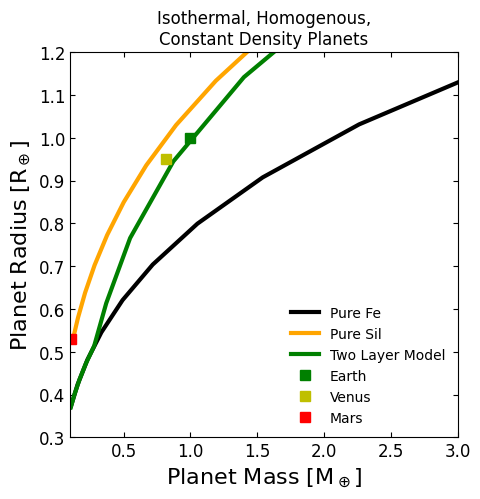

In [6]:
plt.figure(figsize=(5, 5))
plt.plot(mp_fe, rp_fe, 'k', label='Pure Fe', lw=3)
plt.plot(mp_sil, rp_sil, 'orange', label='Pure Sil', lw=3)
plt.plot(mp_cmb, rp_cmb, 'g', label='Two Layer Model', lw=3)
plt.plot(1.0, 1.0, 'gs', markersize=7, label = 'Earth')  # Earth
plt.plot(0.815, 0.951, 'ys', markersize=7, label = 'Venus')  # Venus
plt.plot(0.107, 0.531, 'rs', markersize=7, label = 'Mars')  # Mars

plt.xlim(0.1, 3)
plt.ylim(0.3, 1.2)
plt.tick_params(which='both', direction='in', labelsize=12, top=True, right=True)
plt.xlabel(r'Planet Mass [M$_\oplus$]', fontsize=16)
plt.ylabel(r'Planet Radius [R$_\oplus$]', fontsize=16)
plt.title('Isothermal, Homogenous,\nConstant Density Planets', loc='center', horizontalalignment='center')

try:
    from labellines import labelLines
    labelLines(fontsize=12)
except:
    plt.legend(loc='lower right', fontsize=10, frameon=False)

plt.show()


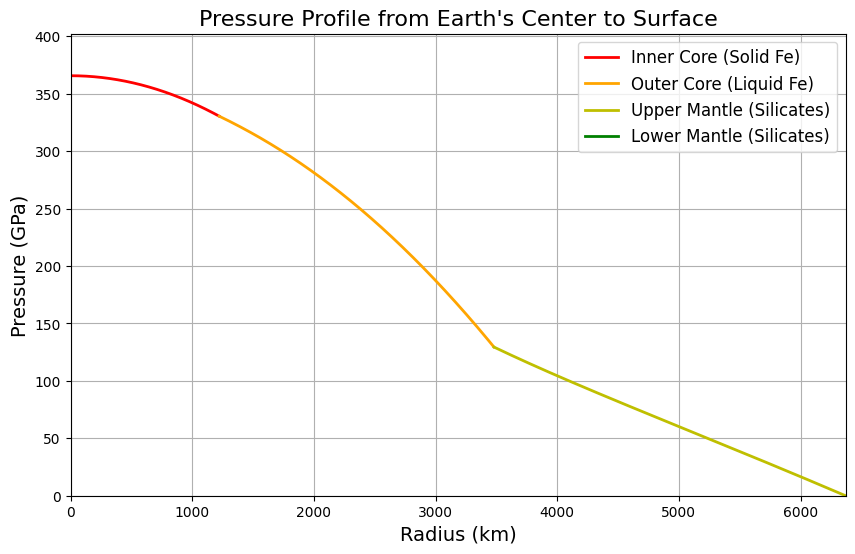

In [15]:
# Core and Mantle Density Values (in kg/m³)
# Inner Core (Solid Iron)
density_inner_core = 13000.0
# Outer Core (Liquid Iron)
density_outer_core = 11500.0
# Upper Mantle (Silicate)
density_upper_mantle = 4500.0
# Lower Mantle (Silicate)
density_lower_mantle = 5200.0

# Define radii for layers (in meters)
inner_core_radius = 1.22e6  # Inner core radius (1220 km)
outer_core_radius = 3.48e6  # Outer core radius (3480 km)
mantle_radius = 6.37e6  # Earth's radius (6371 km)

# Function to return density based on material and radius
def get_rho(r):
    if r < inner_core_radius:  # Inner core (solid Fe)
        return density_inner_core
    elif r < outer_core_radius:  # Outer core (liquid Fe)
        return density_outer_core
    elif r < mantle_radius:  # Upper mantle (silicates)
        return density_upper_mantle
    else:  # Lower mantle (silicates)
        return density_lower_mantle

# Function to calculate the pressure profile with layered core and mantle
def calculate_pressure_profile(dr=100.0, p_surface=0):
    # Initialize arrays, starting from the surface
    radius_array = np.arange(mantle_radius, 0, -dr)  # From surface to center
    pressure_array = np.zeros_like(radius_array)
    mass_array = np.zeros_like(radius_array)

    # Calculate mass profile from surface to center (backwards integration)
    total_mass = 0.0
    for i in range(len(radius_array) - 1, -1, -1):
        r = radius_array[i]
        rho = get_rho(r)
        shell_volume = 4.0 * np.pi * (r**2) * dr
        shell_mass = rho * shell_volume
        total_mass += shell_mass
        mass_array[i] = total_mass

    # Calculate pressure inward
    pressure_array[0] = p_surface  # Surface pressure (0 or atmospheric)
    for i in range(1, len(radius_array)):
        r = radius_array[i-1]
        rho = get_rho(r)
        m = mass_array[i-1]
        g = G * m / (r**2)
        dp = rho * g * dr
        pressure_array[i] = pressure_array[i-1] + dp

    # Convert to GPa
    pressure_array = pressure_array / gpa_to_pa
    radius_array = radius_array[::-1]  # Flip to center-to-surface for plotting
    pressure_array = pressure_array[::-1]

    return radius_array, pressure_array

# Calculate the pressure profile
radius, pressure = calculate_pressure_profile(dr=100.0)  # Use dr = 100 for finer resolution

# Plot the pressure profile with different colors for each region
plt.figure(figsize=(10,6))

# Plot each region with different colors
plt.plot(radius[radius <= inner_core_radius] / 1e3, pressure[radius <= inner_core_radius], 'r-', lw=2, label='Inner Core (Solid Fe)')
plt.plot(radius[(radius > inner_core_radius) & (radius <= outer_core_radius)] / 1e3, pressure[(radius > inner_core_radius) & (radius <= outer_core_radius)], 'orange', lw=2, label='Outer Core (Liquid Fe)')
plt.plot(radius[(radius > outer_core_radius) & (radius <= mantle_radius)] / 1e3, pressure[(radius > outer_core_radius) & (radius <= mantle_radius)], 'y-', lw=2, label='Upper Mantle (Silicates)')
plt.plot(radius[radius > mantle_radius] / 1e3, pressure[radius > mantle_radius], 'g-', lw=2, label='Lower Mantle (Silicates)')

# Label axes
plt.xlabel('Radius (km)', fontsize=14)
plt.ylabel('Pressure (GPa)', fontsize=14)
plt.title('Pressure Profile from Earth\'s Center to Surface', fontsize=16)

# Add grid and legend
plt.grid(True)
plt.xlim(0, re / 1e3)  # Plot until Earth's radius (in km)
plt.ylim(0, max(pressure) * 1.1)  # Set the y-axis to show full pressure range
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()

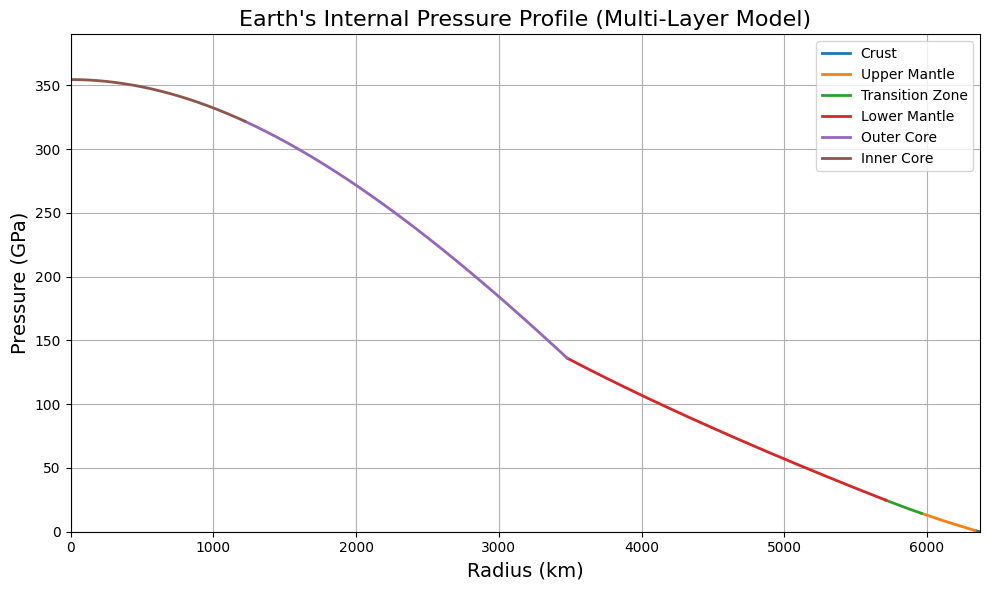

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# === Constants ===
G = 6.67430e-11        # gravitational constant (m³/kg/s²)
gpa_to_pa = 1e9        # 1 GPa = 1e9 Pa
re = 6.371e6           # Earth's radius in meters

# === Earth Layer Structure: (name, r_outer, r_inner, rho_outer, rho_inner) ===
layers = [
    ("Crust",            6.371e6, 6.336e6, 2700, 3000),
    ("Upper Mantle",     6.336e6, 5.961e6, 3300, 3900),
    ("Transition Zone",  5.961e6, 5.711e6, 3900, 4400),
    ("Lower Mantle",     5.711e6, 3.480e6, 4400, 5600),
    ("Outer Core",       3.480e6, 1.220e6, 9900, 12200),
    ("Inner Core",       1.220e6, 0.0,     12200, 13000),
]

# === Density function with linear interpolation ===
def get_density(r):
    for name, r_outer, r_inner, rho_outer, rho_inner in layers:
        if r_inner <= r <= r_outer:
            return rho_inner + (rho_outer - rho_inner) * (r - r_inner) / (r_outer - r_inner)
    return 0  # Outside Earth

# === Pressure profile calculation from surface inward ===
def calculate_pressure_profile(dr=100.0, p_surface=0):
    radius_array = np.arange(re, 0, -dr)  # From surface to center
    pressure_array = np.zeros_like(radius_array)
    mass_array = np.zeros_like(radius_array)

    total_mass = 0.0
    for i in range(len(radius_array)-1, -1, -1):
        r = radius_array[i]
        rho = get_density(r)
        dV = 4 * np.pi * r**2 * dr
        shell_mass = rho * dV
        total_mass += shell_mass
        mass_array[i] = total_mass

    pressure_array[0] = p_surface
    for i in range(1, len(radius_array)):
        r = radius_array[i-1]
        rho = get_density(r)
        m = mass_array[i-1]
        g = G * m / (r**2)
        dp = rho * g * dr
        pressure_array[i] = pressure_array[i-1] + dp

    return radius_array[::-1], (pressure_array[::-1] / gpa_to_pa)  # Flip for plotting center to surface

# === Plotting function with layer coloring ===
def plot_pressure_profile(radius_array, pressure_array):
    plt.figure(figsize=(10, 6))
    km_radius = radius_array / 1e3

    # Plot each layer with a unique color
    color_map = plt.get_cmap("tab10")
    for i, (name, r_outer, r_inner, _, _) in enumerate(layers):
        mask = (radius_array >= r_inner) & (radius_array <= r_outer)
        plt.plot(km_radius[mask], pressure_array[mask], lw=2, label=name, color=color_map(i % 10))

    plt.xlabel("Radius (km)", fontsize=14)
    plt.ylabel("Pressure (GPa)", fontsize=14)
    plt.title("Earth's Internal Pressure Profile (Multi-Layer Model)", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.xlim(0, re / 1e3)
    plt.ylim(0, np.max(pressure_array) * 1.1)
    plt.tight_layout()
    plt.show()

# === Run it ===
radius, pressure = calculate_pressure_profile(dr=100.0)
plot_pressure_profile(radius, pressure)
